<a href="https://colab.research.google.com/github/JuliaM-11/Mentorhub/blob/main/%D0%9F%D1%80%D0%BE%D0%B5%D0%BA%D1%82.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sqlalchemy import create_engine, MetaData
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression

In [ ]:
db_config = {'user': 'mentor',
             'pwd': 'm06uz3.tMQ017y8n',
             'host': '185.86.147.205',
             'port': 5432,
             'db': 'db_mentor'}

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(db_config['user'],
                                                         db_config['pwd'],
                                                         db_config['host'],
                                                         db_config['port'],
                                                         db_config['db'])
engine = create_engine(connection_string)

In [ ]:
def select(sql):
    return pd.io.sql.read_sql(sql, con = engine)

In [ ]:
# количество уникальных пользователей
sql = '''
select  count(*) all_id,
        count(distinct user_id) as all_unique_id
from    users
'''

select(sql)

,all_id,all_unique_id
0,3132,3132


In [ ]:
# зарегистрированные пользователи на платформе
sql = '''
select  role,
        count(user_id) as user_quantity
from    users
group by role
'''

select(sql)

,role,user_quantity
0,mentee,2509
1,mentor,623


In [ ]:
# проверка сессий на уникальность id и сколько всего было проведено сессий
sql = '''
select  count(*) as all_id,
        count(distinct session_id) as all_unique_id
from    sessions
'''

select(sql)

,all_id,all_unique_id
0,6524,6524


In [ ]:
# Пользователи, участвовавшие в сессиях, есть в таблице пользователей (users)
sql = '''
select  count(distinct mentee_id) as mentee_quantity
from    sessions s
where   NOT EXISTS (select user_id from users where mentee_id = user_id)
'''
print('Количество менти, которых нет в users: ', select(sql)['mentee_quantity'].loc[select(sql).index[0]])

sql = '''
select  count(distinct mentor_id) as mentor_quantity
from    sessions s
where   NOT EXISTS (select user_id from users where mentor_id  = user_id)
'''
print('Количество менторов, которых нет в users: ', select(sql)['mentor_quantity'].loc[select(sql).index[0]])

Количество менти, которых нет в users:  0
Количество менторов, которых нет в users:  0


Вывод: предварительно изучив данные, можно сделать вывод, что все пользователи и их id уникальны.

In [ ]:
# Количество пользователей, которые взаимодействуют на платформе каждый месяц. Оценить изменение показателя.
sql = '''
select  date_trunc('month', session_date_time) :: date as session_month,
        count(distinct mentee_id) as mentee_cnt,
        count(distinct mentor_id) as mentor_cnt
from    sessions s
group by session_month
order by session_month
'''

select(sql)

,session_month,mentee_cnt,mentor_cnt
0,2021-02-01,3,3
1,2021-03-01,3,3
2,2021-04-01,7,7
3,2021-05-01,19,18
4,2021-06-01,27,24
5,2021-07-01,35,37
6,2021-08-01,56,53
7,2021-09-01,70,63
8,2021-10-01,89,86
9,2021-11-01,114,102


Вывод: количество пользователей увеличивается от месяца к месяцу, однако, в сентябре 2022г. количество пользователей, принимающих участие в сессиях, меньше, чем в августе 2022г.

In [ ]:
# Проверка полноты месяца (сентябрь 2022г.)
sql = '''
select  max(session_date_time) as max_date
from    sessions s
'''

select(sql)

,max_date
0,2022-09-15


Вывод: за сентябрь 2022г. представлены данные только за половину месяца, поэтому снижение показателя нельзя считать ухудшающим.

In [ ]:
# Количество пользователей, которые ещё не приняли участие в сессиях
sql = '''
select  count(distinct user_id) filter (where "role" = 'mentee') as mentee_quantity
from    users u
where   NOT EXISTS (select mentee_id from sessions where mentee_id = user_id)
'''

print('Количество менти, которые не приняли участие ни в одной сессии: ', select(sql)['mentee_quantity'].loc[select(sql).index[0]])

sql = '''
select  count(distinct user_id) filter (where "role" = 'mentor') as mentor_quantity
from    users u
where  NOT EXISTS (select mentor_id from sessions where mentor_id = user_id)
'''

print('Количество менторов, которые не приняли участие ни в одной сессии: ', select(sql)['mentor_quantity'].loc[select(sql).index[0]])

Количество менти, которые не приняли участие ни в одной сессии:  2509
Количество менторов, которые не приняли участие ни в одной сессии:  623


Сгруппируем пользователей по дате регистрации и региону, чтобы оценить, из каких регионов пользователи не принимают участие в сессиях.

In [ ]:
# Пользователи по дате регистрации
sql = '''
select  date_trunc('month', reg_date) :: date as created_month,
        count(user_id) filter (where "role" = 'mentee') as mentee_quantity,
        count(user_id) filter (where "role" = 'mentor') as mentor_quantity
from    users u
where   NOT EXISTS (select mentee_id from sessions where mentee_id = user_id) and NOT EXISTS (select mentor_id from sessions where mentor_id = user_id)
group by created_month
order by created_month
'''
select(sql)

,created_month,mentee_quantity,mentor_quantity
0,2021-01-01,130,27
1,2021-02-01,106,37
2,2021-03-01,153,24
3,2021-04-01,103,26
4,2021-05-01,128,16
5,2021-06-01,121,30
6,2021-07-01,144,29
7,2021-08-01,118,29
8,2021-09-01,118,28
9,2021-10-01,132,32


In [ ]:
# Пользователи по региону
sql = '''
select  r."name" as region_name,
        count(id) filter (where "role" = 'mentee') as mentee_quantity,
        count(id) filter (where "role" = 'mentor') as mentor_quantity
from    users u
        left join region r
        on u.region_id = r.id
where   NOT EXISTS (select mentee_id from sessions where mentee_id = user_id) and NOT EXISTS (select mentor_id from sessions where mentor_id = user_id)
group by r."name"
order by mentee_quantity DESC, mentor_quantity DESC
'''

select(sql).head(5)

,region_name,mentee_quantity,mentor_quantity
0,г Москва,1016,258
1,г Санкт-Петербург,254,63
2,Ростовская обл,243,69
3,Краснодарский край,200,58
4,Ленинградская обл,196,36


Вывод: пользователи из г. Москвы не пользуются платфорой.

In [ ]:
# Доля пользователей (менти по региону)
sql = '''
with data_preparation as (
select  u.user_id,
        r."name" as region_name,
        exists(
                select 1
                from sessions s
                where u.user_id = s.mentee_id
) has_session
from users u
left join region r
on u.region_id = r.id
where u."role" = 'mentee'
)
select  region_name,
        count(user_id) as all_user,
        round(count(user_id) filter (where has_session is False) :: numeric / count(user_id), 2) as user_without_session_mentee
from    data_preparation
group by region_name
order by all_user DESC, user_without_session_mentee DESC
'''

select(sql)

,region_name,all_user,user_without_session_mentee
0,г Москва,1016,0.27
1,г Санкт-Петербург,254,0.28
2,Ростовская обл,243,0.29
3,Краснодарский край,200,0.25
4,Ленинградская обл,196,0.25
5,Московская обл,157,0.27
6,Другое,130,0.22
7,Нижегородская обл,121,0.28
8,Новосибирская обл,79,0.24
9,Омская обл,45,0.33


In [ ]:
select(sql)['user_without_session_mentee'].describe()

,user_without_session_mentee
count,15.000000
mean,0.284000
std,0.101896
min,0.110000
25%,0.245000
50%,0.270000
75%,0.290000
max,0.500000


Вывод: рассмотрев долю пользователей по региону и статистические показатели можно сделать вывод, что доля пользователей (г.Москва) близка к медианному значению (Q2). Нельзя однозначно заявить о влиянии региона на прохождение сессий.

In [ ]:
# Сколько у каждого ментора в среднем сессий в неделю по месяцам
sql = '''
with month_week_table as(
select mentor_id,
      date_trunc('month', session_date_time) :: date session_month,
      extract(month from session_date_time) month_n,
      extract(week from session_date_time) week_n,
      count(session_id) session_per_week
from sessions s
where session_status = 'finished'
group by mentor_id, session_month, month_n, week_n
)
select  mentor_id,
        session_month :: date,
        month_n :: int,
        avg(session_per_week) :: int avg_session_per_week
from    month_week_table
group by mentor_id, session_month, month_n
order by avg_session_per_week DESC
'''
select(sql).head(5)

,mentor_id,session_month,month_n,avg_session_per_week
0,3802,2022-09-01,9,15
1,772,2022-09-01,9,10
2,4123,2022-09-01,9,8
3,3105,2022-09-01,9,8
4,3347,2022-09-01,9,7


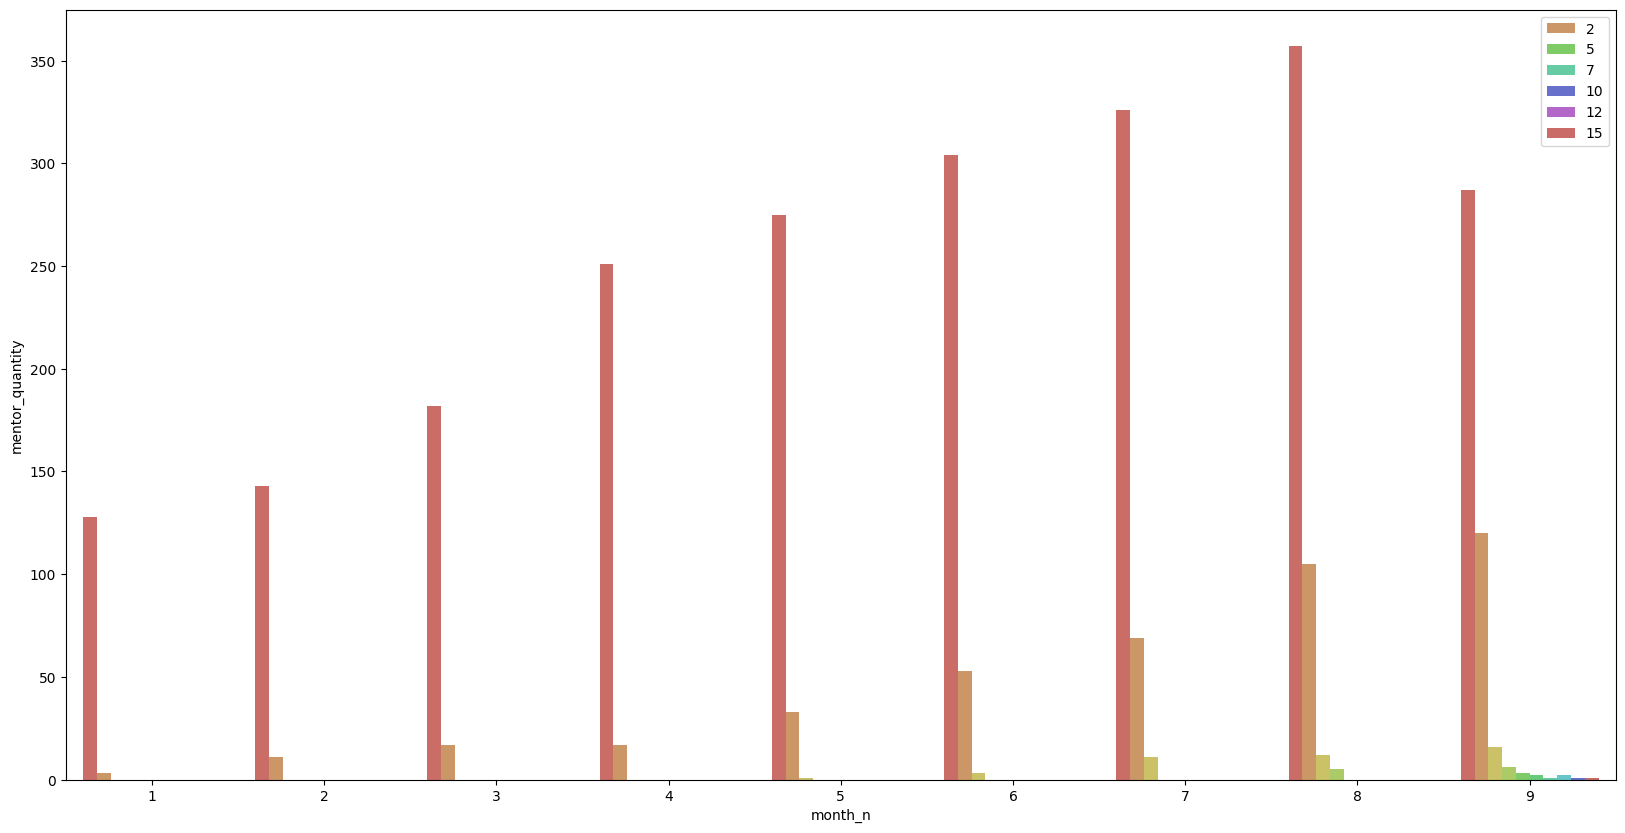

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(data=(select(sql).astype({'session_month' : 'datetime64[ns]'})
                  .query("session_month >= '2022-01-01'")
                  .groupby(['month_n', 'avg_session_per_week'])
                  .agg(mentor_quantity = ('mentor_id', 'nunique'))
                  .reset_index()),
            x="month_n", y="mentor_quantity",
            hue="avg_session_per_week",  palette='hls')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

Вывод: с мая часть менторов стали проводить в среднем более 2 сессий в неделю. В сентябре есть менторы, которые провели 5 и более сессий.

In [ ]:
# ТОП 5 менторов по количеству сессий за последний полный месяц

sql = '''
with session_per_mentor as(
select  mentor_id,
        count(session_id) as session_quantity
from    sessions s
where   session_date_time :: date between '2022-08-01' AND '2022-08-31'
group by mentor_id
),
session_quantity_numeration as(
select  mentor_id,
        session_quantity,
        dense_rank () over (order by session_quantity DESC) as dr
FROM    session_per_mentor
)
SELECT  mentor_id
FROM    session_quantity_numeration
WHERE   dr <= 5
                '''

select(sql)

,mentor_id
0,4256
1,2192
2,1903
3,1552
4,4798
5,3855
6,328
7,4015
8,1357


In [ ]:
# Время между сессиями(меторы/дни)
sql = '''
with next_session_dt_preparation as (
select  mentor_id,
            session_date_time,
            lead (session_date_time) over (partition by mentor_id order by session_date_time) as next_session_dt,
            row_number () over (partition by mentor_id order by session_date_time) rn
from sessions s
),
day_diff_table as(
select  *,
        date_part('day', next_session_dt - session_date_time) as day_diff
from next_session_dt_preparation
where rn = 1
)
select  mentor_id,
        day_diff
from    day_diff_table
'''

select(sql)


,mentor_id,day_diff
0,7,30.0
1,15,7.0
2,16,0.0
3,26,23.0
4,27,17.0
...,...,...
618,4920,17.0
619,4923,10.0
620,4968,36.0
621,4976,30.0


In [ ]:
select(sql)['day_diff'].describe()

,day_diff
count,623.000000
mean,46.797753
std,57.018282
min,0.000000
25%,7.000000
50%,25.000000
75%,62.000000
max,326.000000


In [ ]:
# Время между сессиями(менти/дни)
sql = '''
with next_session_dt_preparation as(
select mentee_id,
      session_date_time,
      lead (session_date_time) over (partition by mentee_id order by session_date_time) as next_session_dt,
      row_number () over (partition by mentee_id order by session_date_time) rn
from sessions s
),
day_diff_table as(
select  *,
        date_part('day', next_session_dt - session_date_time) as day_diff
from next_session_dt_preparation
where rn = 1
)
select  mentee_id,
        day_diff
from    day_diff_table
'''

select(sql)

,mentee_id,day_diff
0,1,168.0
1,5,49.0
2,6,173.0
3,13,153.0
4,18,66.0
...,...,...
1842,4964,1.0
1843,4970,31.0
1844,4972,65.0
1845,4980,NaN


In [ ]:
select(sql)['day_diff'].describe()

,day_diff
count,1497.000000
mean,74.554442
std,82.103397
min,0.000000
25%,16.000000
50%,46.000000
75%,107.000000
max,509.000000


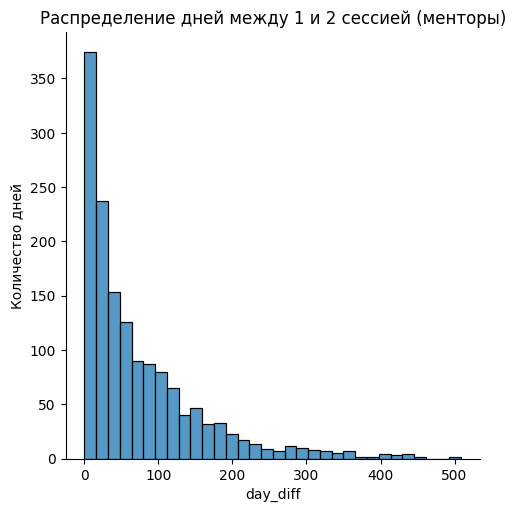

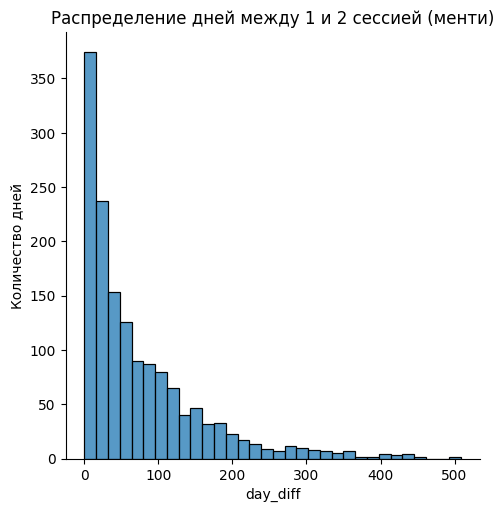

In [ ]:
sns.displot(data=select(sql), x="day_diff")
plt.title('Распределение дней между 1 и 2 сессией (менторы)')
plt.ylabel('Количество дней')
plt.show()

sns.displot(data=select(sql), x="day_diff")
plt.title('Распределение дней между 1 и 2 сессией (менти)')
plt.ylabel('Количество дней')
plt.show()

Вывод: Распределения имеют длинные хвосты, но 50% пользователей, которые приняли участие во второй сессии сделали это в течение месяца (для менторов) и в течение полутора месяцев для менти.

In [ ]:
# Количество отмененных сессий в месяц и доля отмененных сессий.
sql = '''
select  date_trunc('month', session_date_time) :: date session_month,
        count(session_id) all_session,
        round(count(session_id) filter (where session_status = 'canceled') :: numeric/ count(session_id), 2) canceled_percent
from sessions
where session_date_time :: date < '2022-09-01'
group by session_month
order by session_month
'''

select(sql)

,session_month,all_session,canceled_percent
0,2021-02-01,3,0.00
1,2021-03-01,3,0.00
2,2021-04-01,7,0.29
3,2021-05-01,19,0.21
4,2021-06-01,27,0.15
5,2021-07-01,37,0.19
6,2021-08-01,59,0.10
7,2021-09-01,71,0.13
8,2021-10-01,101,0.11
9,2021-11-01,119,0.20


In [ ]:
select(sql)['canceled_percent'].describe()

,canceled_percent
count,19.000000
mean,0.151053
std,0.067321
min,0.000000
25%,0.130000
50%,0.160000
75%,0.185000
max,0.290000


Вывод: Медиана и среднее значение досточно близки. Это значит, что наша метрика (доля отмен) не склонна к выбросам.

In [ ]:
# В какой день недели последнего полного месяца прошло больше всего встреч
sql = '''
with session_per_week_day as(
select  d."name" domain_name,
        to_char(s.session_date_time, 'dy') week_day,
        count(session_id) session_quantity
from sessions s
inner join "domain" d
on s.mentor_domain_id = d.id
where session_date_time :: date BETWEEN '2022-08-01' AND '2022-08-31'
group by domain_name, week_day
),
dense_rank_table as(
select  *,
dense_rank() over (partition by domain_name order by session_quantity DESC) dr
from session_per_week_day
)
select  domain_name,
        week_day,
        session_quantity
from dense_rank_table
where dr = 1
'''

select(sql)

,domain_name,week_day,session_quantity
0,AB тестирование,tue,27
1,DS,wed,40
2,Python для аналитики данных,wed,40
3,SQL,mon,47
4,Визуализация данных,wed,29
5,Машинное обучение,tue,42
6,Продуктовая аналитика,sun,35


Вывод: среда является самым загруженным днём по количеству встреч.

In [ ]:
#сколько новых менторов нужно найти, если в следующем месяце количество активных менти увеличится на 500 человек
sql = '''
select  date_trunc('month', session_date_time) :: date,
        count(distinct  mentor_id) mentor_cnt,
        count(distinct mentee_id) mentee_cnt
from sessions s
group by 1
order by 1
'''

select(sql).tail(3)

,date_trunc,mentor_cnt,mentee_cnt
17,2022-07-01,446,684
18,2022-08-01,509,883
19,2022-09-01,469,757


In [ ]:
# Подсчет коэффициента линейной регрессии и прогнозирование

x = select(sql)['mentee_cnt'].to_numpy().reshape((-1, 1))
y = select(sql)['mentor_cnt'].to_numpy()

model = LinearRegression().fit(x, y)

x_new = np.append(x, x[-1] + 500).reshape((-1, 1))
y_new = model.predict(x_new)

print("Потребуется менторов: ", round(y_new[-1], 0))
print("Потребуется найти менторов: ", round(y_new[-1], 0) - round(y[-1], 0))

Потребуется менторов:  792.0
Потребуется найти менторов:  323.0


Вывод: при увеличении числа менти на 500 человек, потребуется найти 323 ментора.